In [ ]:
from src.simulators import CustomerGenerator, compute_lognormal_parameters, FraudulentTxnGenerator
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import pandas as pd


seed = 99

group_profiles = {
    'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
    'txn_mean_low': [5, 20, 40, 60, 80],
    'txn_mean_high': [20, 40, 60, 80, 100],
    'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
    'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
    'txn_lambda': [0.25, 0.5, 1, 1.5, 2] # to simplify, we assume middle income person has average 1 txn per day
}

## 1. Illustrations of Customer Profiles and Their Spending Habits

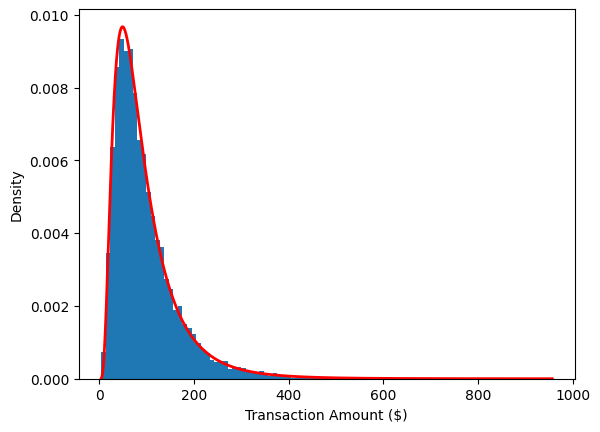

In [12]:
# Generate lognormal txn_value
mean_txn = 96.49 # mean of raw txn value
cv = 0.75 # coefficient of variation
mu, sigma = compute_lognormal_parameters(mean_txn, cv)
size = 10000

np.random.seed(seed)
txn_values = np.random.lognormal(mean=mu, sigma=sigma, size=size)

# Create histogram
count, bins, ignored = plt.hist(txn_values, 100, density=True, align='mid')

# create lognormal pdf
# source: https://numpy.org/doc/2.1/reference/random/generated/numpy.random.lognormal.html
x = np.linspace(min(bins), max(bins), size)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')

plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.show()

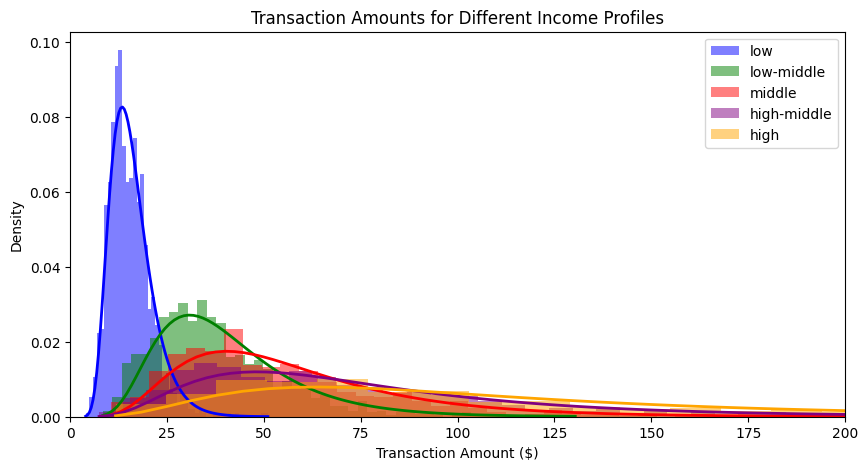

In [21]:
# Illustrating the spending habit of the groups above by generate 1000 transactions for a customer of each profile
np.random.seed(seed)

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(10, 5))
for i, profile in enumerate(group_profiles['name']):
    profile_dict = {key: group_profiles[key][i] for key in group_profiles}

    mean_amount = np.random.uniform(profile_dict["txn_mean_low"], profile_dict["txn_mean_high"])
    cv = np.random.uniform(profile_dict["txn_cv_low"], profile_dict["txn_cv_high"])

    mu, sigma = compute_lognormal_parameters(mean_amount, cv)
    txn_value = np.random.lognormal(mean=mu, sigma=sigma, size=1000)
    
    # Plot histogram
    plt.hist(txn_value, bins=50, density=True, alpha=0.5, label=profile, color=colors[i])
    
    # Calculate and plot PDF
    x = np.linspace(txn_value.min(), txn_value.max(), 100)
    pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean_amount)))
    plt.plot(x, pdf, color=colors[i], lw=2)

plt.xlim(0, 200)
plt.title('Transaction Amounts for Different Income Profiles')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend()
plt.show()


middle
{'txn_mean': 52.13, 'txn_mu': 3.804392501922574, 'txn_sigma': 0.5465310546665042, 'txn_lambda': 1}
Average total transaction value: $1931.51
sample transactions
{'txn_id': 't_7a74bc7450', 'txn_timestamp': '2024-01-01 10:50:32', 'txn_date': '2024-01-01', 'txn_value': 95.5, 'txn_fraud': 0, 'txn_fraud_scenario': 0}


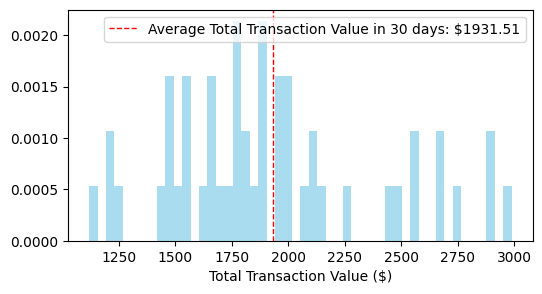

In [22]:
# Illustrate the spending habit of a customer with a specific profile
profile_name = 'middle'
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile(profile_name)
print(profile_name)
print(customer.profile)

num_days = 30
num_trials = 50
total_txn_values = []
for trial in range(num_trials):
    customer_txns = customer.generate_batch_txns(num_days=num_days)
    total_txn_values.append(round(sum([txn["txn_value"] for txn in customer_txns]), 2))
# average total transaction value over all trials
avg_total_txn_value = round(np.mean(total_txn_values), 2)
print(f"Average total transaction value: ${avg_total_txn_value}")
# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(total_txn_values, bins=50, density=True, alpha=0.7, color="skyblue")
plt.xlabel("Total Transaction Value ($)")
# add average total transaction value to the plot
plt.axvline(
    avg_total_txn_value,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Average Total Transaction Value in {num_days} days: ${avg_total_txn_value}",
)
plt.legend()

print("sample transactions")
print(customer_txns[0])

## 2. Simulation of Customers and their Legitimate Transactions

In [24]:
# setting boundaries
start_date="2024-01-01"
num_days=365
txn_data = []
customer_data = []
num_customers = 10000

# generate customers and their transactions
for i in range(1,num_customers+1):
    # generate customer
    customer_id_num = 1000000 + i
    customer_id = f"c_{str(1000000 + i)[1:]}"
    customer_generator = CustomerGenerator(group_profiles)
    profile_name = random.choice(group_profiles["name"]) # random profile
    customer = customer_generator.generate_customer_from_profile(profile_name)

    # generate transactions for that customer
    customer_txns = customer.generate_batch_txns(num_days=num_days, start_date=start_date)

    # append to main dataset
    txn_data.append({"customer_id":customer_id, "customer_txns":customer_txns})
    customer_dict = customer.profile
    customer_dict["customer_id"] = customer_id
    customer_dict["profile_name"] = profile_name
    customer_data.append(customer_dict)

# convert to pandas dataframes
df_customers = pd.DataFrame(customer_data)
df_txns = pd.DataFrame(
    [
        {"customer_id": row["customer_id"], **txn}
        for row in txn_data
        for txn in row["customer_txns"]
    ]
)

# rearrange by timestamp to simulate the real-world scenario
df_txns.sort_values(by="txn_timestamp", inplace=True)
df_txns.reset_index(drop=True, inplace=True)

## 3. Simulation of Fraudulent Transactions

In [26]:
# pick a number of random customers from all customers
n_affected_customers = 200
random.seed(seed) # this ensures the same customers are picked each time the code is run
affected_customers = random.sample(df_customers["customer_id"].tolist(), n_affected_customers)
dates = df_txns["txn_date"].unique()
# generate fraudulent transactions for each customer
# assuming that each customer is affected only once and by one of three scenarios
fraudulent_txns = []
fraudulent_txn_generator = FraudulentTxnGenerator()
for customer_id in affected_customers:
    date = random.choice(dates)
    scenario = random.choice([1, 2, 3])
    fraudulent_txns.extend(
        fraudulent_txn_generator.generate_fraudulent_txns(
            customer_id=customer_id, scenario=scenario, date=date
        )
    )

df_fraudulent_txns = pd.DataFrame(fraudulent_txns)

## 4. Combining the Legitimate and Fraudulent Transactions

In [28]:
# check that the columns are the same
assert all(df_fraudulent_txns.columns == df_txns.columns)

In [29]:
# append the fraudulent transactions to the main dataset
df_all_txns = pd.concat([df_txns, df_fraudulent_txns], ignore_index=True)
df_all_txns.sort_values(by="txn_timestamp", inplace=True, ascending=False)
df_all_txns.reset_index(drop=True, inplace=True)

In [38]:
# some statistics
print("Number of legitimate and fraudulent transactions:")
print(df_all_txns.groupby("txn_fraud").size())
print("="*50)

print("Percentage of fraudulent transactions:")
print(df_all_txns.groupby("txn_fraud").size() / len(df_all_txns) * 100)
print("="*50)

print("Number of affected customers:")
print(df_all_txns[df_all_txns["txn_fraud"] == 1]["customer_id"].nunique())
print("="*50)

print("Breakdown of fraudulent transactions by scenario:")
print(df_all_txns[df_all_txns["txn_fraud"] == 1].groupby("txn_fraud_scenario").size())
print("="*50)

Number of legitimate and fraudulent transactions:
txn_fraud
0    3731440
1       1950
dtype: int64
Percentage of fraudulent transactions:
txn_fraud
0    99.947769
1     0.052231
dtype: float64
Number of affected customers:
200
Breakdown of fraudulent transactions by scenario:
txn_fraud_scenario
1    1111
2     466
3     373
dtype: int64


## 5. Save the Data to a CSV File

In [ ]:
# # make dir if not exist
# import os
# if not os.path.exists("data"):
#     os.makedirs("data")

# # save the data
# df_customers.to_csv("data/customers.csv", index=False)
# df_all_txns.to_csv("data/transactions.csv", index=False)